# Agriculture Dataset

In [52]:
# Load Libraries
import lightgbm as lgb
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import seaborn as sns
from collections import Counter
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)

In [53]:
# Load given train data
df_train = pd.read_csv('agritrain.csv', header=0)
df_train

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1
...,...,...,...,...,...,...,...,...,...,...
88853,F00155935,3337,1,0,2,10,12.0,44,3,0
88854,F00155938,3516,1,0,2,10,20.0,38,1,0
88855,F00155939,3516,1,0,2,15,40.0,8,2,0
88856,F00155942,3702,1,0,2,10,25.0,18,3,0


In [54]:
# Load given test data
df_test = pd.read_csv('agritest.csv', header=0)
df_test

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
0,F00000002,188,1,1,1,0,NaN,0,2
1,F00000007,410,1,1,1,0,0.0,0,2
2,F00000011,626,1,0,1,0,0.0,0,2
3,F00000013,731,1,0,1,0,0.0,0,2
4,F00000014,789,0,0,1,0,0.0,0,1
...,...,...,...,...,...,...,...,...,...
59305,F00155937,3337,1,0,2,20,34.0,12,1
59306,F00155940,3516,1,0,2,20,32.0,10,2
59307,F00155941,3702,1,0,2,10,NaN,48,1
59308,F00155943,3702,1,0,2,10,28.0,17,2


In [55]:
# Load given submission data
submission = pd.read_csv('submission.csv')
submission

,ID,Crop_Damage
0,F00000002,1.0
1,F00000007,1.0
2,F00000011,1.0
3,F00000013,1.0
4,F00000014,1.0
...,...,...
54846,F00144159,0.0
54847,F00144160,0.0
54848,F00144161,0.0
54849,F00144170,1.0


In [56]:
# Let's check shape of train and test data and concat train and test data
df_train['train_flag'] = 1
df_test['train_flag'] = 0
df_test['Crop_Damage'] = 0
print(df_train.shape, df_test.shape)

df_data = pd.concat((df_train, df_test))
print(df_data.shape)

(88858, 11) (59310, 11)
(148168, 11)


In [57]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('train_flag')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season']


In [58]:
df_data['ID_value'] = df_data['ID'].apply(lambda x: x.strip('F')).astype('int')

In [59]:
df_data = df_data.sort_values(['ID_value'])

In [60]:
df_data = df_data.reset_index(drop=True)

In [61]:
df_data['Soil_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Crop_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Pesticide_Use_Category_Damage'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Season_Damage'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Soil_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Crop_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Pesticide_Use_Category_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Season_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

In [62]:
df_data.loc[df_data['train_flag'] == 0, 'Crop_Damage'] = -999

In [63]:
df_data['Crop_Damage_lag1'] = df_data['Crop_Damage'].shift(fill_value=-999)
df_data['Estimated_Insects_Count_lag1'] = df_data['Estimated_Insects_Count'].shift(fill_value=-999)
df_data['Crop_Type_lag1'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag1'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag1'] = df_data['Pesticide_Use_Category'].shift(fill_value=-999)
df_data['Number_Doses_Week_lag1'] = df_data['Number_Doses_Week'].shift(fill_value=-999)
df_data['Number_Weeks_Used_lag1'] = df_data['Number_Weeks_Used'].shift(fill_value=-999)
df_data['Number_Weeks_Quit_lag1'] = df_data['Number_Weeks_Quit'].shift(fill_value=-999)
df_data['Season_lag1'] = df_data['Season'].shift(fill_value=-999)

df_data['Crop_Damage_lag2'] = df_data['Crop_Damage'].shift(periods=2,fill_value=-999)
df_data['Estimated_Insects_Count_lag2'] = df_data['Estimated_Insects_Count'].shift(periods=2,fill_value=-999)
df_data['Crop_Type_lag2'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag2'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag2'] = df_data['Pesticide_Use_Category'].shift(periods=2,fill_value=-999)
df_data['Number_Doses_Week_lag2'] = df_data['Number_Doses_Week'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Used_lag2'] = df_data['Number_Weeks_Used'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Quit_lag2'] = df_data['Number_Weeks_Quit'].shift(periods=2,fill_value=-999)
df_data['Season_lag2'] = df_data['Season'].shift(periods=2,fill_value=-999)

In [64]:
df_train, df_test = df_data[df_data.train_flag == 1], df_data[df_data.train_flag == 0]

In [65]:
df_train.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['train_flag'], inplace=True, axis=1)
df_test.drop([label_col], inplace=True, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [66]:
# Let's see train annd test shape
print(df_train.shape, df_test.shape)

(88858, 39) (59310, 38)


In [67]:
del df_data

In [68]:
missing_impute = -999

In [69]:
df_train['Number_Weeks_Used'] = df_train['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used'] = df_test['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag1'] = df_train['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag1'] = df_test['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag2'] = df_train['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag2'] = df_test['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)

In [70]:
df_train, df_eval = train_test_split(df_train, test_size=0.40, random_state=42, shuffle=True, stratify=df_train[label_col])

In [71]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('ID_value')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season', 'Soil_Type_Damage', 'Estimated_Insects_Count_Damage', 'Crop_Type_Damage', 'Pesticide_Use_Category_Damage', 'Season_Damage', 'Soil_Type_Damage_lag2', 'Estimated_Insects_Count_Damage_lag2', 'Crop_Type_Damage_lag2', 'Pesticide_Use_Category_Damage_lag2', 'Season_Damage_lag2', 'Crop_Damage_lag1', 'Estimated_Insects_Count_lag1', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Number_Doses_Week_lag1', 'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Season_lag1', 'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2', 'Crop_Type_lag2', 'Soil_Type_lag2', 'Pesticide_Use_Category_lag2', 'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2', 'Number_Weeks_Quit_lag2', 'Season_lag2']


In [72]:
cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Season_lag1']

In [73]:
params = {}
params['learning_rate'] = 0.04
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11
params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

In [74]:
clf = lgb.LGBMClassifier(**params)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)

eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Crop_Type', 'Crop_Type_lag1', 'Pesticide_Use_Category', 'Pesticide_Use_Category_lag1', 'Season', 'Season_lag1', 'Soil_Type', 'Soil_Type_lag1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.489931	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.490077
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.465409	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.46577
[3]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.444815	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.445455
[4]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.429632	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.43065
[5]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.413898	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.415111
[6]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.401722	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.40321
[7]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.391755	valid_1's multi_error: 0.164528	valid_1's multi_logloss

[61]	valid_0's multi_error: 0.0700191	valid_0's multi_logloss: 0.203801	valid_1's multi_error: 0.0723329	valid_1's multi_logloss: 0.213437
[62]	valid_0's multi_error: 0.0696252	valid_0's multi_logloss: 0.202551	valid_1's multi_error: 0.0720234	valid_1's multi_logloss: 0.212325
[63]	valid_0's multi_error: 0.0693251	valid_0's multi_logloss: 0.201559	valid_1's multi_error: 0.0714045	valid_1's multi_logloss: 0.21146
[64]	valid_0's multi_error: 0.0688562	valid_0's multi_logloss: 0.200557	valid_1's multi_error: 0.0712075	valid_1's multi_logloss: 0.210631
[65]	valid_0's multi_error: 0.0683123	valid_0's multi_logloss: 0.199283	valid_1's multi_error: 0.0708699	valid_1's multi_logloss: 0.209453
[66]	valid_0's multi_error: 0.0680497	valid_0's multi_logloss: 0.198405	valid_1's multi_error: 0.0706167	valid_1's multi_logloss: 0.208715
[67]	valid_0's multi_error: 0.0677496	valid_0's multi_logloss: 0.197432	valid_1's multi_error: 0.0702228	valid_1's multi_logloss: 0.207853
[68]	valid_0's multi_error: 

[121]	valid_0's multi_error: 0.0563829	valid_0's multi_logloss: 0.164404	valid_1's multi_error: 0.0628517	valid_1's multi_logloss: 0.181515
[122]	valid_0's multi_error: 0.0563642	valid_0's multi_logloss: 0.164041	valid_1's multi_error: 0.0627673	valid_1's multi_logloss: 0.18128
[123]	valid_0's multi_error: 0.0562892	valid_0's multi_logloss: 0.163614	valid_1's multi_error: 0.0625703	valid_1's multi_logloss: 0.180972
[124]	valid_0's multi_error: 0.0562141	valid_0's multi_logloss: 0.163156	valid_1's multi_error: 0.0625703	valid_1's multi_logloss: 0.180634
[125]	valid_0's multi_error: 0.0562892	valid_0's multi_logloss: 0.162821	valid_1's multi_error: 0.0625703	valid_1's multi_logloss: 0.180447
[126]	valid_0's multi_error: 0.0560453	valid_0's multi_logloss: 0.162349	valid_1's multi_error: 0.0623171	valid_1's multi_logloss: 0.180115
[127]	valid_0's multi_error: 0.055914	valid_0's multi_logloss: 0.16204	valid_1's multi_error: 0.0622609	valid_1's multi_logloss: 0.179963
[128]	valid_0's multi_e

[181]	valid_0's multi_error: 0.0509435	valid_0's multi_logloss: 0.146104	valid_1's multi_error: 0.059363	valid_1's multi_logloss: 0.170076
[182]	valid_0's multi_error: 0.0508872	valid_0's multi_logloss: 0.145869	valid_1's multi_error: 0.0593068	valid_1's multi_logloss: 0.169897
[183]	valid_0's multi_error: 0.0508122	valid_0's multi_logloss: 0.145679	valid_1's multi_error: 0.0592224	valid_1's multi_logloss: 0.169815
[184]	valid_0's multi_error: 0.0506621	valid_0's multi_logloss: 0.145445	valid_1's multi_error: 0.0590254	valid_1's multi_logloss: 0.169676
[185]	valid_0's multi_error: 0.0506434	valid_0's multi_logloss: 0.145285	valid_1's multi_error: 0.0591098	valid_1's multi_logloss: 0.169655
[186]	valid_0's multi_error: 0.0505496	valid_0's multi_logloss: 0.145037	valid_1's multi_error: 0.059138	valid_1's multi_logloss: 0.16953
[187]	valid_0's multi_error: 0.050437	valid_0's multi_logloss: 0.14486	valid_1's multi_error: 0.0590254	valid_1's multi_logloss: 0.169484
[188]	valid_0's multi_err

[240]	valid_0's multi_error: 0.0473984	valid_0's multi_logloss: 0.134823	valid_1's multi_error: 0.0570842	valid_1's multi_logloss: 0.164791
[241]	valid_0's multi_error: 0.0473422	valid_0's multi_logloss: 0.134685	valid_1's multi_error: 0.0572248	valid_1's multi_logloss: 0.164769
[242]	valid_0's multi_error: 0.0471734	valid_0's multi_logloss: 0.134543	valid_1's multi_error: 0.0573093	valid_1's multi_logloss: 0.164753
[243]	valid_0's multi_error: 0.0470421	valid_0's multi_logloss: 0.134341	valid_1's multi_error: 0.0573374	valid_1's multi_logloss: 0.164636
[244]	valid_0's multi_error: 0.0469108	valid_0's multi_logloss: 0.134165	valid_1's multi_error: 0.0572811	valid_1's multi_logloss: 0.164583
[245]	valid_0's multi_error: 0.0468732	valid_0's multi_logloss: 0.134041	valid_1's multi_error: 0.0573374	valid_1's multi_logloss: 0.164571
[246]	valid_0's multi_error: 0.0467982	valid_0's multi_logloss: 0.133884	valid_1's multi_error: 0.0573093	valid_1's multi_logloss: 0.164502
[247]	valid_0's mult

[299]	valid_0's multi_error: 0.0432532	valid_0's multi_logloss: 0.125827	valid_1's multi_error: 0.0560432	valid_1's multi_logloss: 0.160924
[300]	valid_0's multi_error: 0.0432157	valid_0's multi_logloss: 0.125707	valid_1's multi_error: 0.0560432	valid_1's multi_logloss: 0.160886
[301]	valid_0's multi_error: 0.0431969	valid_0's multi_logloss: 0.125605	valid_1's multi_error: 0.0560713	valid_1's multi_logloss: 0.160872
[302]	valid_0's multi_error: 0.0431406	valid_0's multi_logloss: 0.125502	valid_1's multi_error: 0.0560432	valid_1's multi_logloss: 0.160826
[303]	valid_0's multi_error: 0.0429906	valid_0's multi_logloss: 0.125338	valid_1's multi_error: 0.0560995	valid_1's multi_logloss: 0.160742
[304]	valid_0's multi_error: 0.0428405	valid_0's multi_logloss: 0.125196	valid_1's multi_error: 0.0560432	valid_1's multi_logloss: 0.160681
[305]	valid_0's multi_error: 0.0428405	valid_0's multi_logloss: 0.12503	valid_1's multi_error: 0.0559869	valid_1's multi_logloss: 0.160586
[306]	valid_0's multi

[360]	valid_0's multi_error: 0.0398582	valid_0's multi_logloss: 0.117971	valid_1's multi_error: 0.0555649	valid_1's multi_logloss: 0.158419
[361]	valid_0's multi_error: 0.0397457	valid_0's multi_logloss: 0.117862	valid_1's multi_error: 0.0555649	valid_1's multi_logloss: 0.158396
[362]	valid_0's multi_error: 0.0396894	valid_0's multi_logloss: 0.117757	valid_1's multi_error: 0.0555649	valid_1's multi_logloss: 0.158367
[363]	valid_0's multi_error: 0.0397644	valid_0's multi_logloss: 0.117676	valid_1's multi_error: 0.0555649	valid_1's multi_logloss: 0.158367
[364]	valid_0's multi_error: 0.0396894	valid_0's multi_logloss: 0.117361	valid_1's multi_error: 0.0553961	valid_1's multi_logloss: 0.158117
[365]	valid_0's multi_error: 0.0395956	valid_0's multi_logloss: 0.117226	valid_1's multi_error: 0.0553961	valid_1's multi_logloss: 0.158025
[366]	valid_0's multi_error: 0.0396331	valid_0's multi_logloss: 0.11709	valid_1's multi_error: 0.0552555	valid_1's multi_logloss: 0.157956
[367]	valid_0's multi

[422]	valid_0's multi_error: 0.0369509	valid_0's multi_logloss: 0.110329	valid_1's multi_error: 0.0546365	valid_1's multi_logloss: 0.155629
[423]	valid_0's multi_error: 0.0369321	valid_0's multi_logloss: 0.110231	valid_1's multi_error: 0.0546084	valid_1's multi_logloss: 0.155596
[424]	valid_0's multi_error: 0.0368571	valid_0's multi_logloss: 0.110135	valid_1's multi_error: 0.0546084	valid_1's multi_logloss: 0.155601
[425]	valid_0's multi_error: 0.0368196	valid_0's multi_logloss: 0.110025	valid_1's multi_error: 0.0545521	valid_1's multi_logloss: 0.155575
[426]	valid_0's multi_error: 0.0368571	valid_0's multi_logloss: 0.109922	valid_1's multi_error: 0.0545521	valid_1's multi_logloss: 0.15557
[427]	valid_0's multi_error: 0.0367258	valid_0's multi_logloss: 0.109783	valid_1's multi_error: 0.0546084	valid_1's multi_logloss: 0.155512
[428]	valid_0's multi_error: 0.0366883	valid_0's multi_logloss: 0.109697	valid_1's multi_error: 0.0546084	valid_1's multi_logloss: 0.155516
[429]	valid_0's multi

[484]	valid_0's multi_error: 0.0342124	valid_0's multi_logloss: 0.103527	valid_1's multi_error: 0.0532861	valid_1's multi_logloss: 0.153365
[485]	valid_0's multi_error: 0.0341374	valid_0's multi_logloss: 0.103449	valid_1's multi_error: 0.0533142	valid_1's multi_logloss: 0.153353
[486]	valid_0's multi_error: 0.0341561	valid_0's multi_logloss: 0.103362	valid_1's multi_error: 0.0533705	valid_1's multi_logloss: 0.153316
[487]	valid_0's multi_error: 0.0341186	valid_0's multi_logloss: 0.103249	valid_1's multi_error: 0.0533705	valid_1's multi_logloss: 0.153276
[488]	valid_0's multi_error: 0.0340811	valid_0's multi_logloss: 0.103172	valid_1's multi_error: 0.0533423	valid_1's multi_logloss: 0.153287
[489]	valid_0's multi_error: 0.0339873	valid_0's multi_logloss: 0.103064	valid_1's multi_error: 0.0533142	valid_1's multi_logloss: 0.153254
[490]	valid_0's multi_error: 0.0339311	valid_0's multi_logloss: 0.102977	valid_1's multi_error: 0.0533142	valid_1's multi_logloss: 0.153238
[491]	valid_0's mult

[544]	valid_0's multi_error: 0.0321116	valid_0's multi_logloss: 0.0979312	valid_1's multi_error: 0.0524983	valid_1's multi_logloss: 0.151825
[545]	valid_0's multi_error: 0.0320929	valid_0's multi_logloss: 0.097826	valid_1's multi_error: 0.0525264	valid_1's multi_logloss: 0.151792
[546]	valid_0's multi_error: 0.0320741	valid_0's multi_logloss: 0.0977281	valid_1's multi_error: 0.0525546	valid_1's multi_logloss: 0.151766
[547]	valid_0's multi_error: 0.0320179	valid_0's multi_logloss: 0.0976326	valid_1's multi_error: 0.0525546	valid_1's multi_logloss: 0.151736
[548]	valid_0's multi_error: 0.0319616	valid_0's multi_logloss: 0.0975512	valid_1's multi_error: 0.0525264	valid_1's multi_logloss: 0.151727
[549]	valid_0's multi_error: 0.0319053	valid_0's multi_logloss: 0.0974649	valid_1's multi_error: 0.0525264	valid_1's multi_logloss: 0.151726
[550]	valid_0's multi_error: 0.031849	valid_0's multi_logloss: 0.0972702	valid_1's multi_error: 0.0523858	valid_1's multi_logloss: 0.151555
[551]	valid_0's

[604]	valid_0's multi_error: 0.0299546	valid_0's multi_logloss: 0.0924098	valid_1's multi_error: 0.0519075	valid_1's multi_logloss: 0.150099
[605]	valid_0's multi_error: 0.0298796	valid_0's multi_logloss: 0.0923356	valid_1's multi_error: 0.0518794	valid_1's multi_logloss: 0.1501
[606]	valid_0's multi_error: 0.0298608	valid_0's multi_logloss: 0.0922553	valid_1's multi_error: 0.0518512	valid_1's multi_logloss: 0.150096
[607]	valid_0's multi_error: 0.0298233	valid_0's multi_logloss: 0.0921789	valid_1's multi_error: 0.0518231	valid_1's multi_logloss: 0.150084
[608]	valid_0's multi_error: 0.0298046	valid_0's multi_logloss: 0.0921259	valid_1's multi_error: 0.0518231	valid_1's multi_logloss: 0.150089
[609]	valid_0's multi_error: 0.0297858	valid_0's multi_logloss: 0.0920623	valid_1's multi_error: 0.0518231	valid_1's multi_logloss: 0.150077
[610]	valid_0's multi_error: 0.0297483	valid_0's multi_logloss: 0.0919936	valid_1's multi_error: 0.0518794	valid_1's multi_logloss: 0.150086
[611]	valid_0's

[665]	valid_0's multi_error: 0.0279476	valid_0's multi_logloss: 0.0881141	valid_1's multi_error: 0.0519356	valid_1's multi_logloss: 0.149643
[666]	valid_0's multi_error: 0.0279101	valid_0's multi_logloss: 0.0879534	valid_1's multi_error: 0.0518231	valid_1's multi_logloss: 0.149513
[667]	valid_0's multi_error: 0.0278914	valid_0's multi_logloss: 0.0878964	valid_1's multi_error: 0.0517387	valid_1's multi_logloss: 0.149515
[668]	valid_0's multi_error: 0.0278726	valid_0's multi_logloss: 0.0878364	valid_1's multi_error: 0.051795	valid_1's multi_logloss: 0.149528
[669]	valid_0's multi_error: 0.0278163	valid_0's multi_logloss: 0.0877766	valid_1's multi_error: 0.0518794	valid_1's multi_logloss: 0.149512
[670]	valid_0's multi_error: 0.0277601	valid_0's multi_logloss: 0.0876955	valid_1's multi_error: 0.0518512	valid_1's multi_logloss: 0.149506
[671]	valid_0's multi_error: 0.0278351	valid_0's multi_logloss: 0.0876213	valid_1's multi_error: 0.051795	valid_1's multi_logloss: 0.149499
[672]	valid_0's

[727]	valid_0's multi_error: 0.0259407	valid_0's multi_logloss: 0.0836707	valid_1's multi_error: 0.0516824	valid_1's multi_logloss: 0.148604
[728]	valid_0's multi_error: 0.0258656	valid_0's multi_logloss: 0.0836173	valid_1's multi_error: 0.0517106	valid_1's multi_logloss: 0.148622
[729]	valid_0's multi_error: 0.0258281	valid_0's multi_logloss: 0.0835601	valid_1's multi_error: 0.0517387	valid_1's multi_logloss: 0.148616
[730]	valid_0's multi_error: 0.0258094	valid_0's multi_logloss: 0.0835064	valid_1's multi_error: 0.0517106	valid_1's multi_logloss: 0.148619
[731]	valid_0's multi_error: 0.0257906	valid_0's multi_logloss: 0.0834433	valid_1's multi_error: 0.0516824	valid_1's multi_logloss: 0.148623
[732]	valid_0's multi_error: 0.0257906	valid_0's multi_logloss: 0.0833848	valid_1's multi_error: 0.0516262	valid_1's multi_logloss: 0.148625
[733]	valid_0's multi_error: 0.0257343	valid_0's multi_logloss: 0.0833295	valid_1's multi_error: 0.0516543	valid_1's multi_logloss: 0.14862
[734]	valid_0'

[786]	valid_0's multi_error: 0.0242525	valid_0's multi_logloss: 0.0797208	valid_1's multi_error: 0.0508947	valid_1's multi_logloss: 0.147569
[787]	valid_0's multi_error: 0.0241775	valid_0's multi_logloss: 0.0796621	valid_1's multi_error: 0.0509509	valid_1's multi_logloss: 0.147569
[788]	valid_0's multi_error: 0.0241775	valid_0's multi_logloss: 0.0795951	valid_1's multi_error: 0.0509791	valid_1's multi_logloss: 0.147576
[789]	valid_0's multi_error: 0.02414	valid_0's multi_logloss: 0.0795433	valid_1's multi_error: 0.0509228	valid_1's multi_logloss: 0.147586
[790]	valid_0's multi_error: 0.0241025	valid_0's multi_logloss: 0.0794821	valid_1's multi_error: 0.0508947	valid_1's multi_logloss: 0.147589
[791]	valid_0's multi_error: 0.0240275	valid_0's multi_logloss: 0.0794303	valid_1's multi_error: 0.0508384	valid_1's multi_logloss: 0.147594
[792]	valid_0's multi_error: 0.0239899	valid_0's multi_logloss: 0.0793607	valid_1's multi_error: 0.0508384	valid_1's multi_logloss: 0.147585
[793]	valid_0's

[848]	valid_0's multi_error: 0.0222081	valid_0's multi_logloss: 0.0758465	valid_1's multi_error: 0.0503883	valid_1's multi_logloss: 0.147062
[849]	valid_0's multi_error: 0.0222081	valid_0's multi_logloss: 0.0757955	valid_1's multi_error: 0.0503601	valid_1's multi_logloss: 0.147057
[850]	valid_0's multi_error: 0.0221518	valid_0's multi_logloss: 0.0757475	valid_1's multi_error: 0.0504164	valid_1's multi_logloss: 0.147059
[851]	valid_0's multi_error: 0.0221143	valid_0's multi_logloss: 0.0756243	valid_1's multi_error: 0.0502757	valid_1's multi_logloss: 0.146933
[852]	valid_0's multi_error: 0.022058	valid_0's multi_logloss: 0.0755777	valid_1's multi_error: 0.0502757	valid_1's multi_logloss: 0.14694
[853]	valid_0's multi_error: 0.0220205	valid_0's multi_logloss: 0.0755259	valid_1's multi_error: 0.0503038	valid_1's multi_logloss: 0.146936
[854]	valid_0's multi_error: 0.0220205	valid_0's multi_logloss: 0.0754147	valid_1's multi_error: 0.0503038	valid_1's multi_logloss: 0.146854
[855]	valid_0's

[910]	valid_0's multi_error: 0.0204824	valid_0's multi_logloss: 0.0719861	valid_1's multi_error: 0.0496005	valid_1's multi_logloss: 0.145876
[911]	valid_0's multi_error: 0.0205012	valid_0's multi_logloss: 0.0719352	valid_1's multi_error: 0.0496568	valid_1's multi_logloss: 0.145886
[912]	valid_0's multi_error: 0.0205012	valid_0's multi_logloss: 0.0718446	valid_1's multi_error: 0.0496849	valid_1's multi_logloss: 0.145816
[913]	valid_0's multi_error: 0.0205012	valid_0's multi_logloss: 0.0717916	valid_1's multi_error: 0.0496286	valid_1's multi_logloss: 0.1458
[914]	valid_0's multi_error: 0.0204637	valid_0's multi_logloss: 0.0717435	valid_1's multi_error: 0.0496849	valid_1's multi_logloss: 0.145802
[915]	valid_0's multi_error: 0.0204449	valid_0's multi_logloss: 0.0716562	valid_1's multi_error: 0.0496286	valid_1's multi_logloss: 0.145741
[916]	valid_0's multi_error: 0.0203699	valid_0's multi_logloss: 0.0716008	valid_1's multi_error: 0.0495161	valid_1's multi_logloss: 0.145727
[917]	valid_0's

[972]	valid_0's multi_error: 0.0192257	valid_0's multi_logloss: 0.0688643	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.145413
[973]	valid_0's multi_error: 0.0191882	valid_0's multi_logloss: 0.0688223	valid_1's multi_error: 0.0494317	valid_1's multi_logloss: 0.145409
[974]	valid_0's multi_error: 0.0191694	valid_0's multi_logloss: 0.0687695	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145392
[975]	valid_0's multi_error: 0.0191882	valid_0's multi_logloss: 0.0687198	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.145386
[976]	valid_0's multi_error: 0.0191507	valid_0's multi_logloss: 0.068672	valid_1's multi_error: 0.0493192	valid_1's multi_logloss: 0.145376
[977]	valid_0's multi_error: 0.0191319	valid_0's multi_logloss: 0.0686358	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.145384
[978]	valid_0's multi_error: 0.0191694	valid_0's multi_logloss: 0.0685861	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.145387
[979]	valid_0'

[1033]	valid_0's multi_error: 0.0181378	valid_0's multi_logloss: 0.0662601	valid_1's multi_error: 0.0491222	valid_1's multi_logloss: 0.145512
[1034]	valid_0's multi_error: 0.0181191	valid_0's multi_logloss: 0.0662193	valid_1's multi_error: 0.0491785	valid_1's multi_logloss: 0.145517
[1035]	valid_0's multi_error: 0.0180816	valid_0's multi_logloss: 0.0661725	valid_1's multi_error: 0.0491222	valid_1's multi_logloss: 0.14552
[1036]	valid_0's multi_error: 0.0181191	valid_0's multi_logloss: 0.0661276	valid_1's multi_error: 0.0491222	valid_1's multi_logloss: 0.14553
[1037]	valid_0's multi_error: 0.0180816	valid_0's multi_logloss: 0.0660887	valid_1's multi_error: 0.0491222	valid_1's multi_logloss: 0.145538
[1038]	valid_0's multi_error: 0.0180065	valid_0's multi_logloss: 0.0660471	valid_1's multi_error: 0.0491503	valid_1's multi_logloss: 0.145545
[1039]	valid_0's multi_error: 0.0180065	valid_0's multi_logloss: 0.0660014	valid_1's multi_error: 0.0491222	valid_1's multi_logloss: 0.145542
[1040]	v

[1092]	valid_0's multi_error: 0.0168436	valid_0's multi_logloss: 0.0635818	valid_1's multi_error: 0.0491222	valid_1's multi_logloss: 0.145102
[1093]	valid_0's multi_error: 0.0167686	valid_0's multi_logloss: 0.0635381	valid_1's multi_error: 0.0491222	valid_1's multi_logloss: 0.145089
[1094]	valid_0's multi_error: 0.0167686	valid_0's multi_logloss: 0.0634932	valid_1's multi_error: 0.0491503	valid_1's multi_logloss: 0.145108
[1095]	valid_0's multi_error: 0.0167686	valid_0's multi_logloss: 0.0634635	valid_1's multi_error: 0.0492066	valid_1's multi_logloss: 0.145108
[1096]	valid_0's multi_error: 0.0167686	valid_0's multi_logloss: 0.0634194	valid_1's multi_error: 0.0492066	valid_1's multi_logloss: 0.145084
[1097]	valid_0's multi_error: 0.0167498	valid_0's multi_logloss: 0.0633857	valid_1's multi_error: 0.0492066	valid_1's multi_logloss: 0.145093
[1098]	valid_0's multi_error: 0.0167498	valid_0's multi_logloss: 0.0633435	valid_1's multi_error: 0.0491785	valid_1's multi_logloss: 0.145092
[1099]

[1151]	valid_0's multi_error: 0.0158307	valid_0's multi_logloss: 0.0611738	valid_1's multi_error: 0.0490659	valid_1's multi_logloss: 0.144953
[1152]	valid_0's multi_error: 0.0158307	valid_0's multi_logloss: 0.0611399	valid_1's multi_error: 0.0490659	valid_1's multi_logloss: 0.144945
[1153]	valid_0's multi_error: 0.015812	valid_0's multi_logloss: 0.0610741	valid_1's multi_error: 0.0490378	valid_1's multi_logloss: 0.144891
[1154]	valid_0's multi_error: 0.015812	valid_0's multi_logloss: 0.0610398	valid_1's multi_error: 0.0490378	valid_1's multi_logloss: 0.144887
[1155]	valid_0's multi_error: 0.015812	valid_0's multi_logloss: 0.0609956	valid_1's multi_error: 0.0490378	valid_1's multi_logloss: 0.144894
[1156]	valid_0's multi_error: 0.0157557	valid_0's multi_logloss: 0.0609435	valid_1's multi_error: 0.0490378	valid_1's multi_logloss: 0.14488
[1157]	valid_0's multi_error: 0.0157182	valid_0's multi_logloss: 0.0609018	valid_1's multi_error: 0.0490659	valid_1's multi_logloss: 0.144874
[1158]	val

[1211]	valid_0's multi_error: 0.0147241	valid_0's multi_logloss: 0.0589101	valid_1's multi_error: 0.0491503	valid_1's multi_logloss: 0.144952
[1212]	valid_0's multi_error: 0.0147241	valid_0's multi_logloss: 0.0588699	valid_1's multi_error: 0.0491785	valid_1's multi_logloss: 0.144951
[1213]	valid_0's multi_error: 0.0147241	valid_0's multi_logloss: 0.0588393	valid_1's multi_error: 0.0491503	valid_1's multi_logloss: 0.144956
[1214]	valid_0's multi_error: 0.0147241	valid_0's multi_logloss: 0.058802	valid_1's multi_error: 0.0491785	valid_1's multi_logloss: 0.144937
[1215]	valid_0's multi_error: 0.0147428	valid_0's multi_logloss: 0.0587725	valid_1's multi_error: 0.0491503	valid_1's multi_logloss: 0.144945
[1216]	valid_0's multi_error: 0.0147428	valid_0's multi_logloss: 0.058734	valid_1's multi_error: 0.0491785	valid_1's multi_logloss: 0.144961
[1217]	valid_0's multi_error: 0.0147241	valid_0's multi_logloss: 0.058698	valid_1's multi_error: 0.0491222	valid_1's multi_logloss: 0.144959
[1218]	va

In [75]:
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)

{'learning_rate': 0.04, 'max_depth': 18, 'n_estimators': 1159, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.7, 'reg_lambda': 1.11}


In [76]:
df_train = pd.concat((df_train, df_eval))

In [77]:
clf = lgb.LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='multi_error', verbose=False, categorical_feature=cat_cols)

# eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
ACC: 0.976861959530937


In [78]:
preds = clf.predict(df_test[feature_cols])

In [79]:
Counter(df_train['Crop_Damage'])

Counter({0: 74238, 1: 12307, 2: 2313})

In [80]:
Counter(preds)

Counter({1: 8550, 2: 530, 0: 50230})

In [81]:
submission = pd.DataFrame({'ID':df_test['ID'], 'Crop_Damage':preds})

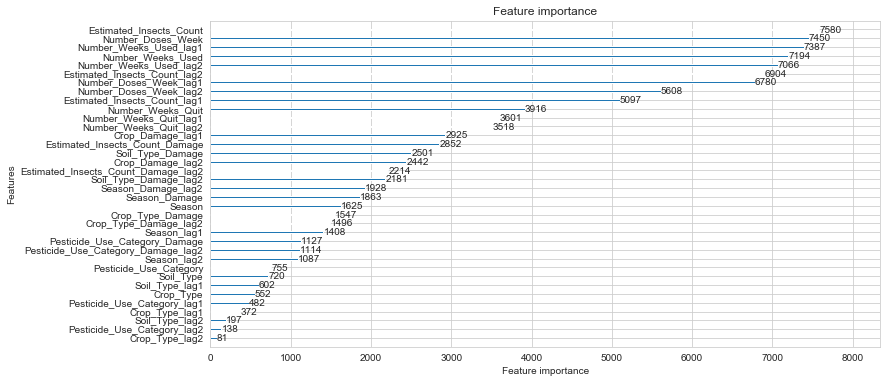

In [82]:
plt.rcParams['figure.figsize'] = (12, 6)
lgb.plot_importance(clf)
plt.show()